In [2]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
data_dir = pathlib.Path("../src/archive/brain_tumor_dataset")
data_dir

WindowsPath('../src/archive/brain_tumor_dataset')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

245


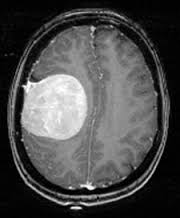

In [5]:
yes = list(data_dir.glob('yes/*'))
PIL.Image.open(str(yes[0]))

In [23]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)




Found 253 files belonging to 2 classes.
Using 203 files for training.


In [24]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 253 files belonging to 2 classes.
Using 50 files for validation.


In [25]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


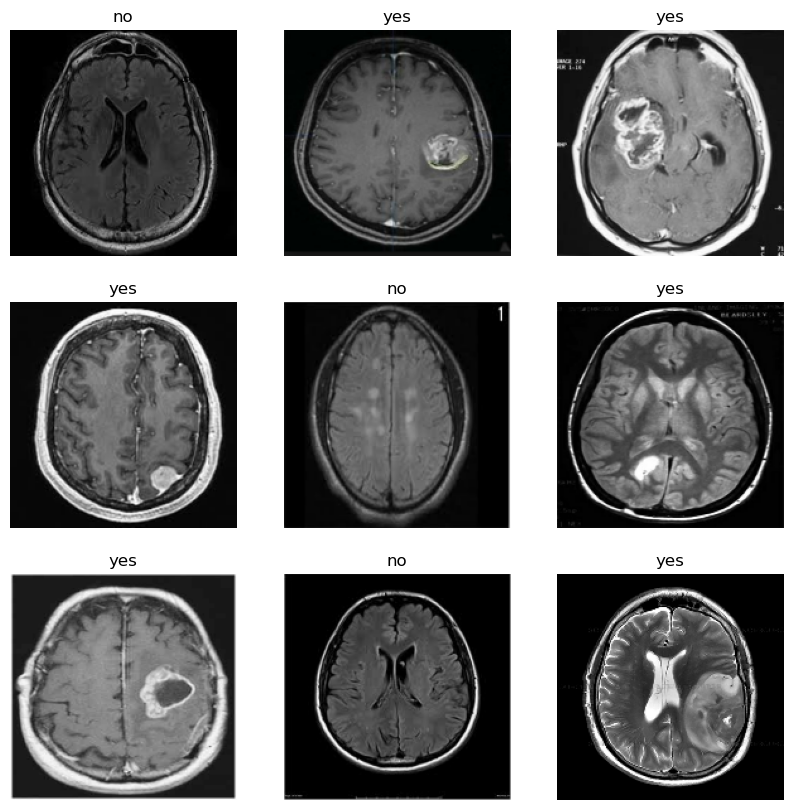

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [27]:
#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.12858456 1.0


In [29]:
first_image = image_batch[6]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [30]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [32]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
7/7 [==============================] - 1s 130ms/step - loss: 0.8734 - accuracy: 0.4877 - val_loss: 0.5546 - val_accuracy: 0.8000
Epoch 2/10
7/7 [==============================] - 1s 100ms/step - loss: 0.5148 - accuracy: 0.7783 - val_loss: 0.6000 - val_accuracy: 0.8000
Epoch 3/10
7/7 [==============================] - 1s 99ms/step - loss: 0.4529 - accuracy: 0.7980 - val_loss: 0.5539 - val_accuracy: 0.8000
Epoch 4/10
7/7 [==============================] - 1s 110ms/step - loss: 0.3983 - accuracy: 0.8030 - val_loss: 0.5787 - val_accuracy: 0.8200
Epoch 5/10
7/7 [==============================] - 1s 106ms/step - loss: 0.3309 - accuracy: 0.8621 - val_loss: 0.6694 - val_accuracy: 0.7400
Epoch 6/10
7/7 [==============================] - 1s 101ms/step - loss: 0.2974 - accuracy: 0.8768 - val_loss: 0.6258 - val_accuracy: 0.8200
Epoch 7/10
7/7 [==============================] - 1s 99ms/step - loss: 0.2131 - accuracy: 0.9310 - val_loss: 0.6781 - val_accuracy: 0.8400
Epoch 8/10
7/7 [======

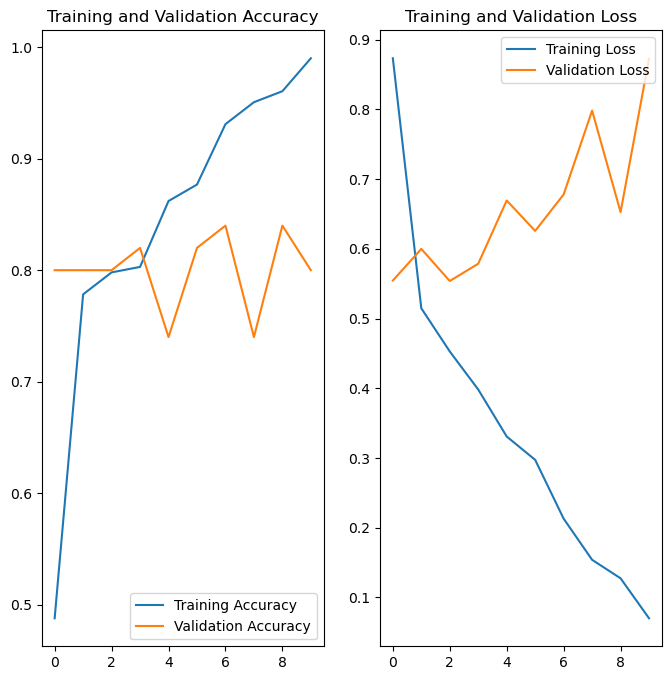

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
predictions = np.array([])
labels =  np.array([])
for x, y in val_ds:
  predictions = np.concatenate([predictions, model.predict(x)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

1/1 [==============================] - 0s 84ms/step


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [34]:
true_categories = tf.concat([y for x, y in val_ds], axis=0)

from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_test, y_pred)

In [40]:
Y_pred = model.predict_generator(val_ds, 63 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print(confusion_matrix(val_ds.predict_x, y_pred))

C:\Users\Nick\AppData\Local\Temp\ipykernel_22664\1366300348.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(val_ds, 63 // batch_size+1)


AttributeError: 'BatchDataset' object has no attribute 'predict_x'